# Justin Barnes

In [1]:
# Imports
%matplotlib inline
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from IPython.display import Image
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook



# Change the common font size (smaller when higher dpi)
font_size = 12
plt.rcParams.update({'font.size': font_size})

# Gravitational Orbit Class

In [7]:
class GravityOrbit:
    """
    This class uses the parameters to solve the Euler-Lagrange equations for two particle orbits where the central
    force is gravity.
    """
    
    def __init__(self, m1 = 1., m2 = 1., g = 1.):
        self.m1 = m1
        self.m2 = m2
        self.g = g

        
        
    def dR_dt(self, t, R):
        """
        This function returns the right-hand side of the diffeq: 
        [dR/dt d^2R/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        R : float
            8-component vector with R[0] = x1, R[1] = x1dot
                                    R[2] = y1, R[3] = y1dot
                                    R[4] = x2, R[5] = x2dot
                                    R[6] = y2, R[7] = y2dot
                                    
        Returns
        ----------
        """
        dist = np.sqrt((R[4] - R[0])**2 + (R[6] - R[2])**2)
        
        return [R[1], self.g * self.m2 * (R[4] - R[0]) / dist**3, \
                R[3], self.g * self.m2 * (R[6] - R[2]) / dist**3, \
                R[5], -self.g * self.m1 * (R[4] - R[0]) / dist**3, \
                R[7], -self.g * self.m1 * (R[6] - R[2]) / dist**3]
    
    
    
    def solve_ode_Leapfrog(self, t_pts, R_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        
        # initialize the arrays for R_0 with zeros
        x1_0, x1dot_0, y1_0, y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0 = R_0
        
        num_t_pts = len(t_pts)
        
        x1_1 = np.zeros(num_t_pts)
        x1dot_1 = np.zeros(num_t_pts)
        x1dot_1_half = np.zeros(num_t_pts)
        
        y1_1 = np.zeros(num_t_pts)
        y1dot_1 = np.zeros(num_t_pts)
        y1dot_1_half = np.zeros(num_t_pts)
        
        x2_1 = np.zeros(num_t_pts)
        x2dot_1 = np.zeros(num_t_pts)
        x2dot_1_half = np.zeros(num_t_pts)

        y2_1 = np.zeros(num_t_pts)
        y2dot_1 = np.zeros(num_t_pts)
        y2dot_1_half = np.zeros(num_t_pts)
        

        # initial conditions
        x1_1[0] = x1_0
        x1dot_1[0] = x1dot_0
        
        y1_1[0] = y1_0
        y1dot_1[0] = y1dot_0
        
        x2_1[0] = x2_0
        x2dot_1[0] = x2dot_0
        
        y2_1[0] = y2_0
        y2dot_1[0] = y2dot_0
        
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            R = [x1_1[i], x1dot_1[i], y1_1[i], y1dot_1[i], x2_1[i], x2dot_1[i], y2_1[i], y2dot_1[i]]
            
            
            x1dot_1_half[i] = x1dot_1[i] + self.dR_dt(t, R)[1] * delta_t/2.
            x1_1[i+1] = x1_1[i] + x1dot_1_half[i] * delta_t
            
            y1dot_1_half[i] = y1dot_1[i] + self.dR_dt(t, R)[3] * delta_t/2.
            y1_1[i+1] = y1_1[i] + y1dot_1_half[i] * delta_t
            
            x2dot_1_half[i] = x2dot_1[i] + self.dR_dt(t, R)[5] * delta_t/2.
            x2_1[i+1] = x2_1[i] + x2dot_1_half[i] * delta_t
            
            y2dot_1_half[i] = y2dot_1[i] + self.dR_dt(t, R)[7] * delta_t/2.
            y2_1[i+1] = y2_1[i] + y2dot_1_half[i] * delta_t
            
            
            R = [x1_1[i+1], x1dot_1[i], y1_1[i+1], y1dot_1[i+1], x2_1[i+1], x2dot_1[i+1], y2_1[i+1], y2dot_1[i+1]]
    
    
            x1dot_1[i+1] = x1dot_1_half[i] + self.dR_dt(t, R)[1] * delta_t/2
            y1dot_1[i+1] = y1dot_1_half[i] + self.dR_dt(t, R)[3] * delta_t/2
            x2dot_1[i+1] = x2dot_1_half[i] + self.dR_dt(t, R)[5] * delta_t/2
            y2dot_1[i+1] = y2dot_1_half[i] + self.dR_dt(t, R)[7] * delta_t/2
            
        return x1_1, x1dot_1, y1_1, y1dot_1, x2_1, x2dot_1, y2_1, y2dot_1
    
    
    
    def solve_ode(self, R_0, t_pts, abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """

        solution = solve_ivp(self.dR_dt, (t_pts[0], t_pts[-1]), R_0, t_eval=t_pts, method='RK23', atol=abserr, rtol=relerr)
        x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot = solution.y
        
        
        return x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot

# Plotting Function

In [8]:
# Pulled from Taylor Problem 7.42 Juypter Noteboook

def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, color=None, linestyle=None, semilogy=False,
                loglog=False, ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line


def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

# Orbit Plots

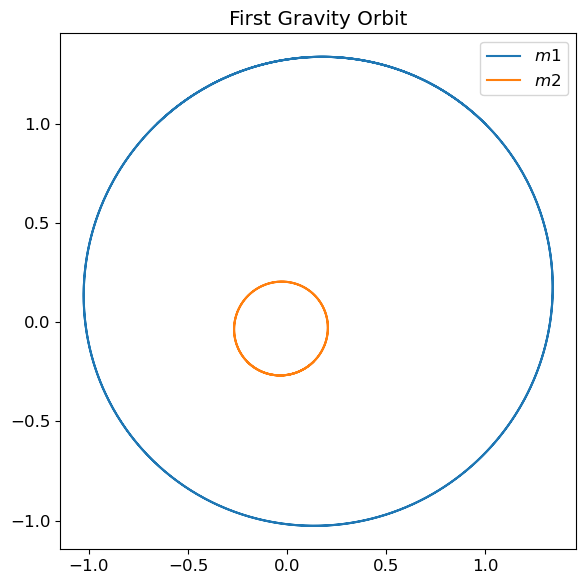

In [10]:
# Plotting time 
t_start = 0.
t_end = 10.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  



# Initialize variables
m1 = 1.
m2 = 5.
g = 1.



# Initialize the first set of orbits
Orbit1 = GravityOrbit(m1, m2, g)



# Initialize an intital center of mass velocity equal to 0
x1_0, x1dot_0 = 1., -1.
y1_0, y1dot_0 = 1., 1.
x2_0, x2dot_0 = -(m1 / m2) * x1_0, -(m1 / m2) * x1dot_0
y2_0, y2dot_0 = -(m1 / m2) * y1_0, -(m1 / m2) * y1dot_0

R_0 = (x1_0, x1dot_0, y1_0, y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0)



# Intialize x, y coordinates
x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot = Orbit1.solve_ode(R_0, t_pts)



# Create the plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x1, y1, label=r'$m1$')
ax.plot(x2, y2, label=r'$m2$')
ax.set_title('First Gravity Orbit')
ax.legend()
ax.set_aspect(1)
fig.tight_layout()

# Heavy Mass Orbit Plot

-4.0 -0.0 -0.0 -30.0


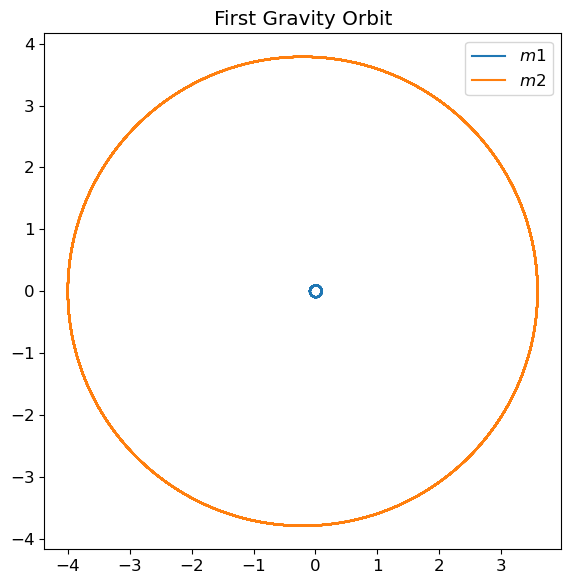

In [11]:
# Plotting time 
t_start = 0.
t_end = 20.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  



# Initialize variables
m1 = 40.
m2 = 1.
g = 100.



# Initialize the first set of orbits
Orbit1 = GravityOrbit(m1, m2, g)



# Initialize an intital center of mass velocity equal to 0
x1_0, x1dot_0 = 0.1, 0.
y1_0, y1dot_0 = 0.0, 0.75
x2_0, x2dot_0 = -(m1 / m2) * x1_0, -(m1 / m2) * x1dot_0
y2_0, y2dot_0 = -(m1 / m2) * y1_0, -(m1 / m2) * y1dot_0

print(x2_0, x2dot_0, y2_0, y2dot_0)

R_0 = (x1_0, x1dot_0, y1_0, y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0)



# Intialize x, y coordinates
x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot = Orbit1.solve_ode(R_0, t_pts)



# Create the plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x1, y1, label=r'$m1$')
ax.plot(x2, y2, label=r'$m2$')
ax.set_title('First Gravity Orbit')
ax.legend()
ax.set_aspect(1)
fig.tight_layout()

When the mass is much larger than the other mass, the orbit looks circular around the larger mass.

# Leapfrog Method

-4.0 -0.0 -0.0 -30.0


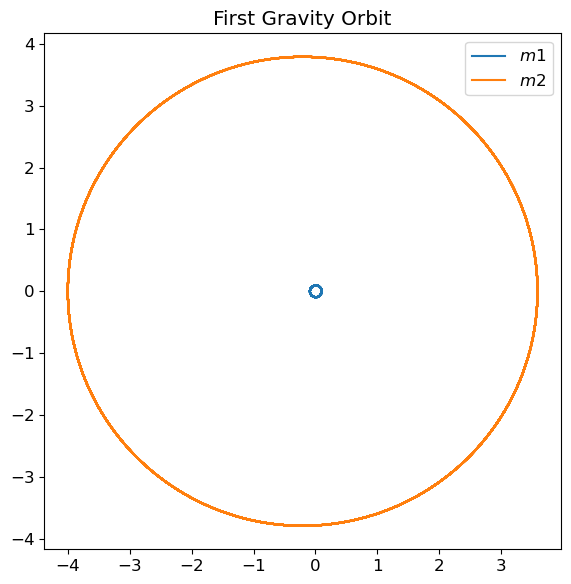

In [9]:
# Plotting time 
t_start = 0.
t_end = 20.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  



# Initialize variables
m1 = 40.
m2 = 1.
g = 100.



# Initialize the first set of orbits
Orbit1 = GravityOrbit(m1, m2, g)



# Initialize an intital center of mass velocity equal to 0
x1_0, x1dot_0 = 0.1, 0.
y1_0, y1dot_0 = 0.0, 0.75
x2_0, x2dot_0 = -(m1 / m2) * x1_0, -(m1 / m2) * x1dot_0
y2_0, y2dot_0 = -(m1 / m2) * y1_0, -(m1 / m2) * y1dot_0

print(x2_0, x2dot_0, y2_0, y2dot_0)

R_0 = (x1_0, x1dot_0, y1_0, y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0)



# Intialize x, y coordinates
x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot = Orbit1.solve_ode_Leapfrog(t_pts, R_0)



# Create the plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x1, y1, label=r'$m1$')
ax.plot(x2, y2, label=r'$m2$')
ax.set_title('First Gravity Orbit')
ax.legend()
ax.set_aspect(1)
fig.tight_layout()

The Leapfrog Method plot is the same as the solve ODE plot.